**Homework 6**

Name:

NetID:

**Setting up our environment**

In this homework we're going to do some pretty intense computing, on rather large amounts of data. This means we're going to start wanting to use GPUs to speed up our code. To turn on a GPU for your notebook, select runtime -> change runtime -> and choose one of the GPU options. Please note that even with using a GPU some of the code may take several minutes to run so please be patient.

I highly highly highly recommend you use an online service like Colab or Kaggle for this homework. The student machines will flat out not work. If you're good enough to manage your own CUDA install on a personal machine then be my guest.

The first thing we need to do is install a special library that provides a version of SVMs that can take advantage of GPU acceleration. This will take several minutes to run.

In [ ]:
# Colab warns and provides remediation steps if the GPUs is not compatible with RAPIDS.

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

**1.) Load and display the MNIST data**

In this homework you'll be applying most of the skills you've learned so far on the MNIST dataset. The MNIST dataset is a collection of handwritten digits, and is often used as a benchmark for machine learning algorithms. For Question 1, you'll load the data and print out what the data looks like.

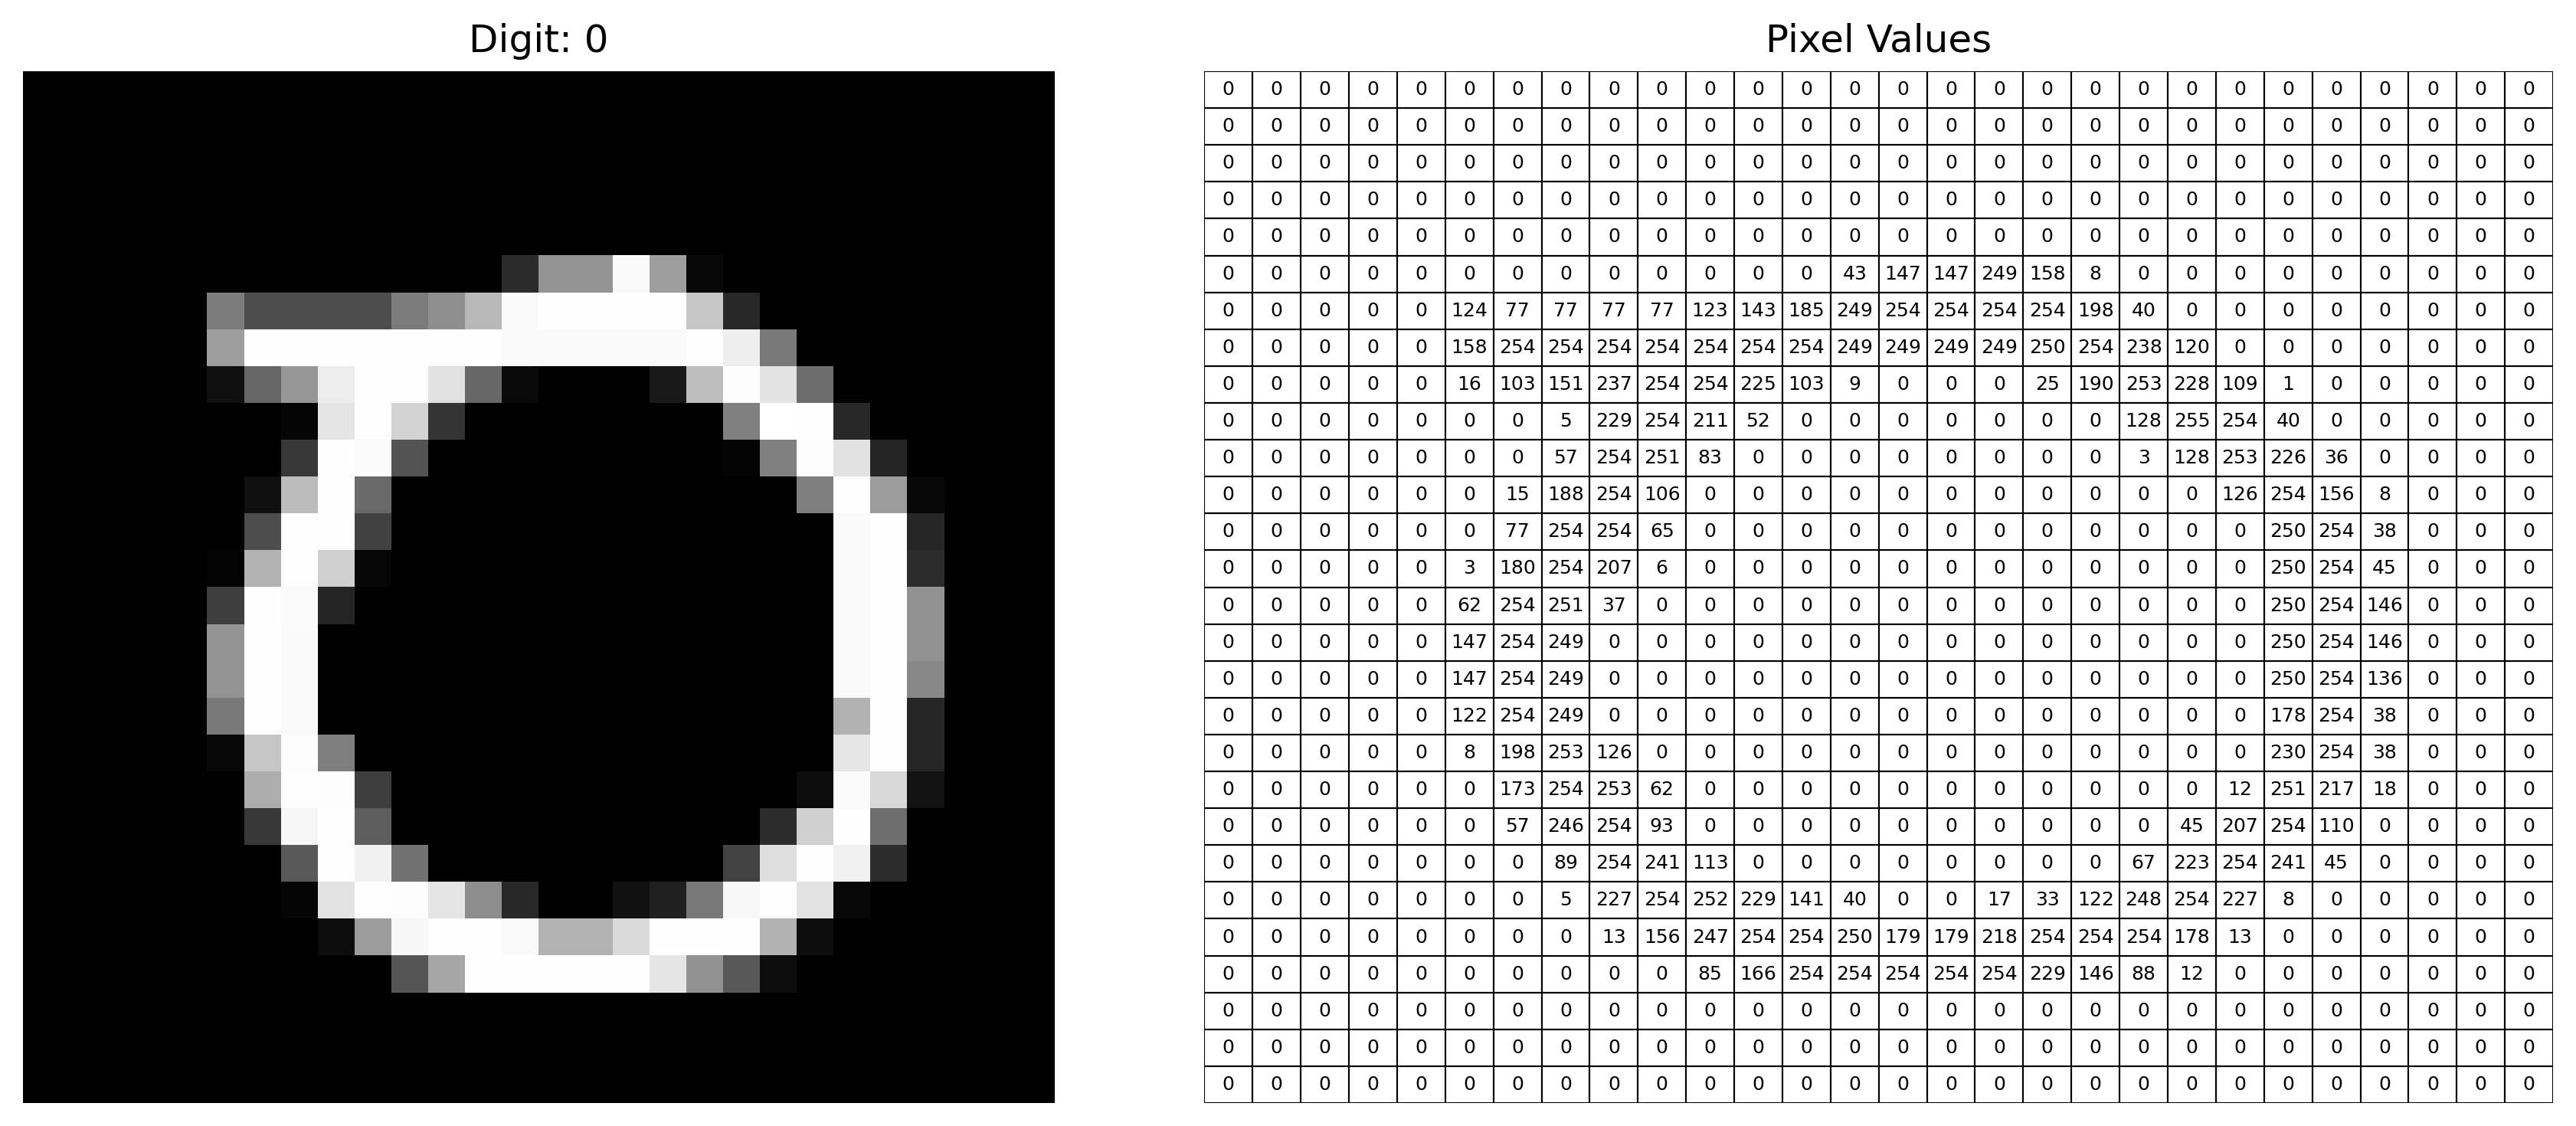

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

X = mnist.data
y = mnist.target.astype(np.int64)  # Convert target to integer labels

# Select a random digit (you can change the index to select a different digit)
index = np.random.randint(0, X.shape[0])

# Get the image and its corresponding pixel values
image = X.iloc[index].values.reshape(28, 28)  # Reshape to 28x28 for plotting

# Create a figure with DPI set to 300
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Plot the digit image on the left
ax[0].imshow(image, cmap='gray')
ax[0].set_title(f"Digit: {y[index]}")
ax[0].axis('off')

# Set a white background for the right plot (removing imshow)
ax[1].set_title('Pixel Values')
ax[1].set_xlim(0, 28)
ax[1].set_ylim(28, 0)  # Invert y-axis for proper row order
ax[1].axis('off')  # Turn off axis

# Plot pixel values in a grid on a white background with boxes around each value
for i in range(28):
    for j in range(28):
        pixel_value = int(image[i, j])
        ax[1].text(j + 0.5, i + 0.5, pixel_value, ha='center', va='center', fontsize=6, color='black')
        # Add a rectangle (box) around each pixel value
        rect = Rectangle((j, i), 1, 1, linewidth=0.5, edgecolor='black', facecolor='none')
        ax[1].add_patch(rect)

plt.tight_layout()
plt.show()

**2.) Unsupervised Exploration**

One thing you may do is run some unsupervised exploration style experiments with clustering methods.

Lets first reduce the dimensions of the MNIST dataset to 2 via PCA to make our results easier to visualize. Then run kmeans clustering below on the mnist dataset and see what you find.

<ipython-input-12-3819b1a7bfd1>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap=plt.cm.get_cmap('Spectral', 10))


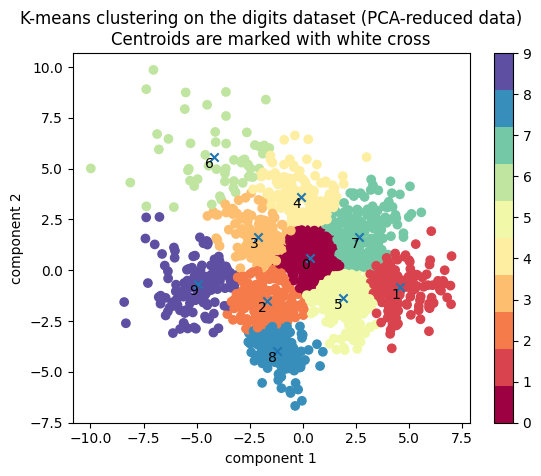

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
h = .02

# TODO: use PCA to find two principle components to use to plot the dataset

# TODO: use kmeans clustering to plot the newley compressed data

centroids = kmeans.cluster_centers_
plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x')
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlabel('component 1')
plt.ylabel('component 2')
labels = ['{0}'.format(i) for i in range(10)]
for i in range (10):
    xy=(centroids[i, 0],centroids[i, 1])
    plt.annotate(labels[i],xy, horizontalalignment='right', verticalalignment='top')
plt.show()

**2.) Create a Naive Bayes model and evaluate its performance**

Use k-fold cross-validation and a Naive Bayes classifier to generate a classification report for the MNIST dataset.

In [ ]:
# Step 2: Preprocess the data
# Naive Bayes typically works better with continuous data, so we scale it
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# TODO: create a new NB classifier

# TODO: use kfold cross validation and the cross_val_score function to collect accuracies

# TODO: create a training and test set and generate a classification_report

Cross-validation scores: [0.52578571 0.538      0.52642857 0.53957143 0.52764286]
Mean cross-validation score: 0.5314857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79      6903
           1       0.85      0.94      0.89      7877
           2       0.88      0.22      0.35      6990
           3       0.71      0.27      0.39      7141
           4       0.83      0.11      0.19      6824
           5       0.51      0.03      0.05      6313
           6       0.68      0.93      0.78      6876
           7       0.92      0.24      0.38      7293
           8       0.26      0.69      0.37      6825
           9       0.37      0.95      0.53      6958

    accuracy                           0.53     70000
   macro avg       0.67      0.52      0.47     70000
weighted avg       0.68      0.53      0.48     70000



Unfortunately, Naive Bayes doesn't work particularly well for this dataset. Lets try something else, maybe an SVM.

**3.) SVMs on MNIST**

Train a linear SVM on the MNIST dataset and evaluate its performance using k-fold cross-validation. Due to the large size of the MNIST dataset we're using, we will need to use a special implementation of SVMs that can leverage the GPU, provided by the CUML package.



In [ ]:
from cuml.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Step 1: Create an SVM classifier with a linear kernel
svm_model = make_pipeline(StandardScaler(), LinearSVC())

# TODO: using the svm model use cross-validation again to generate accuracies

# TODO: using a train and test set get a classification report for the test set

SVM Cross-validation scores: [0.91257143 0.91035714 0.91128571 0.91335714 0.91307143]
SVM Mean cross-validation score: 0.9121285714285715
SVM Classification Report (Test set):
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1343
           1       0.94      0.97      0.95      1600
           2       0.91      0.89      0.90      1380
           3       0.89      0.89      0.89      1433
           4       0.91      0.93      0.92      1295
           5       0.87      0.87      0.87      1273
           6       0.94      0.95      0.95      1396
           7       0.93      0.94      0.93      1503
           8       0.89      0.83      0.86      1357
           9       0.89      0.88      0.89      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



**3.) Nonlinear SVM Kernel**

While a linear SVM did okay, we can probably do better with a nonlinear kernel. Lets try that!

In [ ]:


from cuml.svm import SVC
from sklearn.pipeline import make_pipeline

# Step 1: Create an SVM classifier with a linear kernel
svm_model = make_pipeline(StandardScaler(), SVC())

# TODO: using the svm model use cross-validation again to generate accuracies

# TODO: using a train and test set get a classification report for the test set

SVM Cross-validation scores: [0.96307143 0.96592857 0.96614286 0.96557143 0.96521429]
SVM Mean cross-validation score: 0.9651857142857143
SVM Classification Report (Test set):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1343
           1       0.98      0.99      0.99      1600
           2       0.96      0.96      0.96      1380
           3       0.96      0.95      0.95      1433
           4       0.96      0.97      0.97      1295
           5       0.97      0.96      0.96      1273
           6       0.97      0.98      0.97      1396
           7       0.93      0.97      0.95      1503
           8       0.96      0.95      0.95      1357
           9       0.96      0.94      0.95      1420

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000



**5.) Exploring Neural Networks**

Read over the code below and give it a run, see if you can gain some understanding of what the code below is doing. It implements a basic neural network to perform classification on the MNIST dataset and it (should) get the highest accuracy out of any of the methods we've seen so far.

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 17725243.70it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 495375.65it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4528726.96it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3762695.79it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



Epoch 1: 100%|██████████| 938/938 [00:19<00:00, 47.13it/s, loss=0.46]


Test set: Average loss: 0.2130, Accuracy: 9376/10000 (94%)


Epoch 2: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s, loss=0.421]


Test set: Average loss: 0.1320, Accuracy: 9578/10000 (96%)


Epoch 3: 100%|██████████| 938/938 [00:17<00:00, 53.60it/s, loss=0.271]


Test set: Average loss: 0.1102, Accuracy: 9635/10000 (96%)


Epoch 4: 100%|██████████| 938/938 [00:18<00:00, 49.93it/s, loss=0.163]


Test set: Average loss: 0.0828, Accuracy: 9733/10000 (97%)


Epoch 5: 100%|██████████| 938/938 [00:17<00:00, 53.56it/s, loss=0.282]


Test set: Average loss: 0.0751, Accuracy: 9763/10000 (98%)


Epoch 6: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s, loss=0.143]


Test set: Average loss: 0.0667, Accuracy: 9785/10000 (98%)


Epoch 7: 100%|██████████| 938/938 [00:18<00:00, 50.74it/s, loss=0.113]


Test set: Average loss: 0.0624, Accuracy: 9796/10000 (98%)


Epoch 8: 100%|██████████| 938/938 [00:17<00:00, 53.63it/s, loss=0.166]


Test set: Average loss: 0.0563, Accuracy: 9810/10000 (98%)


Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 51.53it/s, loss=0.124]


Test set: Average loss: 0.0551, Accuracy: 9817/10000 (98%)


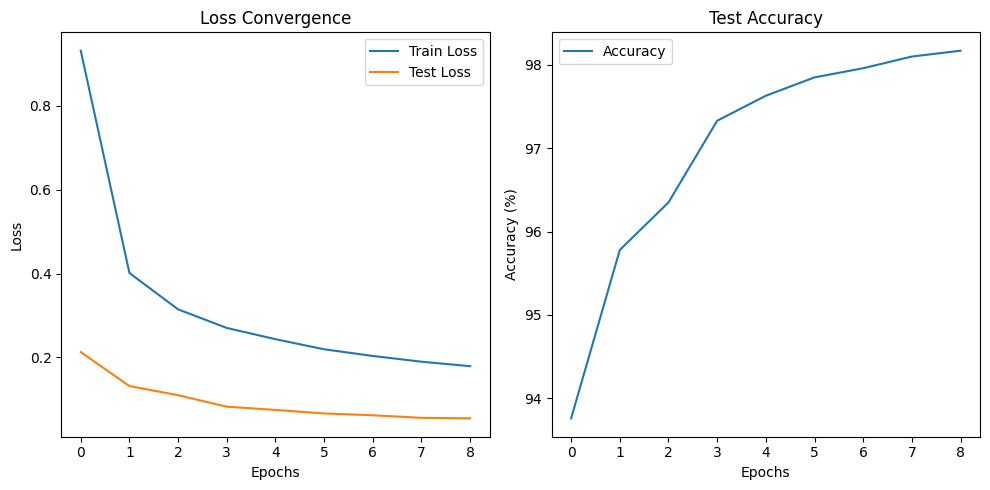

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Data preparation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=False, download=True, transform=transform),
    batch_size=1000, shuffle=False)

# Initialize network, optimizer and device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

train_losses = []
test_losses = []
accuracies = []

# Training loop with tqdm
def train(epoch):
    network.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 10 == 0:
            progress_bar.set_postfix(loss=loss.item())

    train_losses.append(running_loss / len(train_loader))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.0f}%)')

# Run training and testing
for epoch in range(1, 10):
    train(epoch)
    test()

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

**6.) Doing some thinking**

The most important bits of code in the neural network are our class that defines the network "Net", the training loop code, and the test loop code.

Read over those and then in your own words give a high-level explanation of what you think it's doing.